## Subtask 1 (Twitter)

In [1]:
### Importing all the required libraries

import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from __future__ import print_function

import os
import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
import json
from pprint import pprint
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from numpy.random import RandomState
prng = RandomState(1234567890)
import nltk
from nltk.tokenize import word_tokenize

Using TensorFlow backend.


## Importing the datasets

In [55]:
# importing the JSON data

with open('C:\\Users\mites\Documents\Cognitive\Midterm\Rawdata\ssix-project-semeval-2017-task-5-subtask-1-beadeb1fd0f9\Microblog_Trainingdata.json') as data_file:    
    data = json.load(data_file)

pprint(data[:5])

[{'cashtag': '$FB',
  'id': '719659409228451840',
  'sentiment score': '0.366',
  'source': 'twitter',
  'spans': ['watching for bounce tomorrow']},
 {'cashtag': '$LUV',
  'id': '719904304207962112',
  'sentiment score': '0.638',
  'source': 'twitter',
  'spans': ['record number of passengers served in 2015']},
 {'cashtag': '$NFLX',
  'id': '5329774',
  'sentiment score': '-0.494',
  'source': 'stocktwits',
  'spans': ['out $NFLX -.35']},
 {'cashtag': '$DIA',
  'id': '719891468173844480',
  'sentiment score': '0.460',
  'source': 'twitter',
  'spans': ['Looking for a strong bounce', 'Lunchtime rally coming']},
 {'cashtag': '$PLUG',
  'id': '20091246',
  'sentiment score': '0.403',
  'source': 'stocktwits',
  'spans': ['Very intrigued with the technology and growth potential']}]


In [4]:
#importing test data

with open('C:\\Users\mites\Documents\Cognitive\Midterm\Rawdata\ssix-project-semeval-2017-task-5-subtask-1-beadeb1fd0f9\Microblogs_Testdata.json') as data_file:    
    datatest = json.load(data_file)

pprint(datatest[:5])

[{'cashtag': '$COST',
  'id': 709723193125175300,
  'source': 'twitter',
  'spans': 'consumers keep cautious stance'},
 {'cashtag': '$CTRP',
  'id': 719529094652698600,
  'source': 'twitter',
  'spans': 'Close $CTRP @46.16 from 43.55 entry +6%;$;+6%'},
 {'cashtag': '$INTC',
  'id': 39048670,
  'source': 'stocktwits',
  'spans': 'Every Reason to Be Bullish'},
 {'cashtag': '$PANW',
  'id': 37048093,
  'source': 'stocktwits',
  'spans': '$PANW need anoth $1 to all time high'},
 {'cashtag': '$JRCC',
  'id': 6207860,
  'source': 'stocktwits',
  'spans': 'Long setup'}]


## Encoding the sentiment scores

In [56]:
idss = [x["id"] for x in data]
spanss = [x["spans"] for x in data]
sources = [x["source"] for x in data]
cashtags = [x["cashtag"] for x in data]
score = [x["sentiment score"] for x in data]

In [6]:
result= list(map(float, score))
sentscr=[]
for item in result:
   
    if item>=-1 and item<=-0.3:
        sentscr.append(-1)
    elif item>-0.3 and item<=0.3:
        sentscr.append(0)
    else: 
        sentscr.append(1)
        
sentscr[:5]

[1, 1, -1, 1, 1]

In [64]:
vv = sentscr[:1700]

In [65]:
vvv = np.array(vv).reshape(1,-1)

## Putting the data into dataframe

In [9]:
df = pd.DataFrame(
    {'id':ids,
     'source': source,
     'cashtag':cashtag,
     'sentimentscore': sentscr,
    })
df[:10]

,cashtag,id,sentimentscore,source
0,$FB,719659409228451840,1,twitter
1,$LUV,719904304207962112,1,twitter
2,$NFLX,5329774,-1,stocktwits
3,$DIA,719891468173844480,1,twitter
4,$PLUG,20091246,1,stocktwits
5,$GMCR,5819749,0,stocktwits
6,$IBM,709741154393133056,0,twitter
7,$JOSB,17892972,-1,stocktwits
8,$CSTM,709834259687710720,-1,twitter
9,$PYPL,708481442079068160,1,twitter


In [10]:
df1 = pd.DataFrame(
    {'spans':spans
    })
df1[:10]

,spans
0,[watching for bounce tomorrow]
1,[record number of passengers served in 2015]
2,[out $NFLX -.35]
3,"[Looking for a strong bounce, Lunchtime rally ..."
4,[Very intrigued with the technology and growth...
5,"[short worked, puts up]"
6,[overbought]
7,"[absolute garbage still up, stores TOTALLY EMP..."
8,[Biggest Market Losers]
9,[Love this company long time.]


In [11]:
a = df1.spans.astype(str).str.replace('\[|\]|\'', '')
a[:10]

0                         watching for bounce tomorrow
1           record number of passengers served in 2015
2                                       out $NFLX -.35
3    Looking for a strong bounce, Lunchtime rally c...
4    Very intrigued with the technology and growth ...
5                                short worked, puts up
6                                           overbought
7    absolute garbage still up, stores TOTALLY EMPT...
8                                Biggest Market Losers
9                         Love this company long time.
Name: spans, dtype: object

In [12]:
df2=a.to_frame()
df2[:10]

,spans
0,watching for bounce tomorrow
1,record number of passengers served in 2015
2,out $NFLX -.35
3,"Looking for a strong bounce, Lunchtime rally c..."
4,Very intrigued with the technology and growth ...
5,"short worked, puts up"
6,overbought
7,"absolute garbage still up, stores TOTALLY EMPT..."
8,Biggest Market Losers
9,Love this company long time.


In [13]:
dataframe = df.join(df2)
dataframe[:10]

,cashtag,id,sentimentscore,source,spans
0,$FB,719659409228451840,1,twitter,watching for bounce tomorrow
1,$LUV,719904304207962112,1,twitter,record number of passengers served in 2015
2,$NFLX,5329774,-1,stocktwits,out $NFLX -.35
3,$DIA,719891468173844480,1,twitter,"Looking for a strong bounce, Lunchtime rally c..."
4,$PLUG,20091246,1,stocktwits,Very intrigued with the technology and growth ...
5,$GMCR,5819749,0,stocktwits,"short worked, puts up"
6,$IBM,709741154393133056,0,twitter,overbought
7,$JOSB,17892972,-1,stocktwits,"absolute garbage still up, stores TOTALLY EMPT..."
8,$CSTM,709834259687710720,-1,twitter,Biggest Market Losers
9,$PYPL,708481442079068160,1,twitter,Love this company long time.


In [14]:
dataframe = dataframe[['id','source','cashtag', 'spans', 'sentimentscore']]
dataframe[:5]

,id,source,cashtag,spans,sentimentscore
0,719659409228451840,twitter,$FB,watching for bounce tomorrow,1
1,719904304207962112,twitter,$LUV,record number of passengers served in 2015,1
2,5329774,stocktwits,$NFLX,out $NFLX -.35,-1
3,719891468173844480,twitter,$DIA,"Looking for a strong bounce, Lunchtime rally c...",1
4,20091246,stocktwits,$PLUG,Very intrigued with the technology and growth ...,1


In [15]:
ids = [x["id"] for x in datatest]
spans = [x["spans"] for x in datatest]
source = [x["source"] for x in datatest]
cashtag = [x["cashtag"] for x in datatest]

In [16]:
dft = pd.DataFrame(
    {'id':ids,
     'source': source,
     'cashtag':cashtag
    })
dft[:10]

,cashtag,id,source
0,$COST,709723193125175300,twitter
1,$CTRP,719529094652698600,twitter
2,$INTC,39048670,stocktwits
3,$PANW,37048093,stocktwits
4,$JRCC,6207860,stocktwits
5,$SBUX,719911771625140200,twitter
6,$TSLA,719571433307955200,twitter
7,$MAR,711874651043926000,twitter
8,$ABBV,719559500852662300,twitter
9,$MS,709737853639663600,twitter


In [17]:
dft1 = pd.DataFrame(
    {'spans':spans
    })
dft1[:10]

,spans
0,consumers keep cautious stance
1,Close $CTRP @46.16 from 43.55 entry +6%;$;+6%
2,Every Reason to Be Bullish
3,$PANW need anoth $1 to all time high
4,Long setup
5,will be a solid long term investmen;$;#passive...
6,recall
7,Marriott wins new Starwood deal by raising cas...
8,Time To Embrace Dividend Growth
9,Bullshit! All #AppleStores are EMPTY in #China...


In [18]:
b = dft1.spans.astype(str).str.replace('\[|$\];|\'', '')
b[:10]

0                       consumers keep cautious stance
1        Close $CTRP @46.16 from 43.55 entry +6%;$;+6%
2                           Every Reason to Be Bullish
3                 $PANW need anoth $1 to all time high
4                                           Long setup
5    will be a solid long term investmen;$;#passive...
6                                               recall
7    Marriott wins new Starwood deal by raising cas...
8                      Time To Embrace Dividend Growth
9    Bullshit! All #AppleStores are EMPTY in #China...
Name: spans, dtype: object

In [19]:
dft2=b.to_frame()
dft2[:10]

,spans
0,consumers keep cautious stance
1,Close $CTRP @46.16 from 43.55 entry +6%;$;+6%
2,Every Reason to Be Bullish
3,$PANW need anoth $1 to all time high
4,Long setup
5,will be a solid long term investmen;$;#passive...
6,recall
7,Marriott wins new Starwood deal by raising cas...
8,Time To Embrace Dividend Growth
9,Bullshit! All #AppleStores are EMPTY in #China...


In [20]:
testdataframe = dft.join(dft2)
testdataframe[:10]

,cashtag,id,source,spans
0,$COST,709723193125175300,twitter,consumers keep cautious stance
1,$CTRP,719529094652698600,twitter,Close $CTRP @46.16 from 43.55 entry +6%;$;+6%
2,$INTC,39048670,stocktwits,Every Reason to Be Bullish
3,$PANW,37048093,stocktwits,$PANW need anoth $1 to all time high
4,$JRCC,6207860,stocktwits,Long setup
5,$SBUX,719911771625140200,twitter,will be a solid long term investmen;$;#passive...
6,$TSLA,719571433307955200,twitter,recall
7,$MAR,711874651043926000,twitter,Marriott wins new Starwood deal by raising cas...
8,$ABBV,719559500852662300,twitter,Time To Embrace Dividend Growth
9,$MS,709737853639663600,twitter,Bullshit! All #AppleStores are EMPTY in #China...


In [21]:
testdataframe = testdataframe[['id','source','cashtag', 'spans']]
testdataframe[:5]

,id,source,cashtag,spans
0,709723193125175300,twitter,$COST,consumers keep cautious stance
1,719529094652698600,twitter,$CTRP,Close $CTRP @46.16 from 43.55 entry +6%;$;+6%
2,39048670,stocktwits,$INTC,Every Reason to Be Bullish
3,37048093,stocktwits,$PANW,$PANW need anoth $1 to all time high
4,6207860,stocktwits,$JRCC,Long setup


## Using Twitter pre-trained word vector

In [22]:
BASE_DIR = 'C:\\Users\mites\Documents\Cognitive\Midterm'
GLOVE_DIR = BASE_DIR + '\glove.twitter.27B'

MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000

# Consider changing the 200 to 25
EMBEDDING_DIM = 200
GLOVE_FILE = 'glove.twitter.27B.200d.txt'

In [23]:
print('Indexing word vectors.')

embeddings_index = {} # word -> coefs
# We'll use the 100-dimensional version
f = open(os.path.join(GLOVE_DIR, GLOVE_FILE), encoding="utf8")

Indexing word vectors.


In [24]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [25]:
X = dataframe.iloc[:,3].values
Xt = testdataframe.iloc[:,3].values

## Tokenizing the words

In [44]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
data = pad_sequences(sequences, maxlen=300)

In [27]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(Xt)
sequences = tokenizer.texts_to_sequences(Xt)
testdata = pad_sequences(sequences, maxlen=30)

In [29]:
print(tokenizer.word_index)

{'the': 1, 'to': 2, 'a': 3, 'in': 4, 'on': 5, 'for': 6, 'is': 7, 'of': 8, 'up': 9, 'and': 10, 'stocks': 11, 'long': 12, 'this': 13, 'buy': 14, 'short': 15, 'be': 16, 'are': 17, 'at': 18, 'today': 19, 'nice': 20, 'with': 21, 'down': 22, 'will': 23, 'it': 24, 'good': 25, 'stock': 26, 'new': 27, 'out': 28, 'looking': 29, 'still': 30, 'market': 31, 'i': 32, 'all': 33, 'day': 34, 'bullish': 35, 'over': 36, 'top': 37, 'call': 38, 'from': 39, 'more': 40, 'now': 41, 'here': 42, 'some': 43, 'not': 44, 'like': 45, 'that': 46, 'its': 47, '5': 48, 'week': 49, 'rally': 50, 'go': 51, 'trade': 52, '2': 53, 'looks': 54, 'into': 55, 'sell': 56, 'has': 57, 'tsla': 58, 'buying': 59, 'fb': 60, 'my': 61, 'aapl': 62, 'strong': 63, 'time': 64, 'support': 65, 'calls': 66, 'no': 67, 'if': 68, 'could': 69, 'off': 70, 'high': 71, 'back': 72, 'have': 73, 'year': 74, 'as': 75, 'higher': 76, 'puts': 77, 'by': 78, 'great': 79, 'shorts': 80, 'close': 81, '3': 82, 'going': 83, 'just': 84, 'sold': 85, 'weak': 86, 'abou

In [30]:
word2index = tokenizer.word_index
len(word2index)

2471

In [31]:
Y = np.array(dataframe.iloc[:,4].values)
Y

array([ 1,  1, -1, ...,  1,  0,  0], dtype=int64)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data,Y, test_size=0.5)

In [33]:
seed = 123
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed) # same shuffle for labels!
np.random.shuffle(y_train)

np.random.seed(seed * 2)
np.random.shuffle(x_test)
np.random.seed(seed * 2)
np.random.shuffle(y_test)

## Padding sequence to convert the train data into two dimension

In [34]:
print('Pad sequences')
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (850, 300)
x_test shape: (850, 300)


In [35]:
# Recall: words are indexed in descending order of frequency. Remove the 
# less frequent ones -- replace with constant value
x_train[x_train >= MAX_NB_WORDS] = MAX_NB_WORDS-1
x_test[x_test >= MAX_NB_WORDS] = MAX_NB_WORDS-1

In [36]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word2index)+1)
#pprint(num_words)
#pprint(len(word2index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2index.items():
    pprint(i)
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054


## Training a MLP model

In [37]:
# train a regular MLP
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(25, activation='linear')(x)
x = Dropout(0.5)(x)
x = Dense(25, activation='linear')(x)
preds = Dense(1, activation='tanh')(x)

model_mlp = Model(sequence_input, preds)
model_mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [38]:
x_train.shape

(850, 300)

In [39]:
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 200)          494400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1500025   
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total para

In [40]:
print('Training model.')
history = model_mlp.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=150, batch_size=32)

Training model.
Train on 850 samples, validate on 850 samples
Epoch 1/150
850/850 [==============================] - ETA: 11s - loss: 0.1653 - acc: 0.37 - ETA: 2s - loss: 0.4165 - acc: 0.3281 - ETA: 1s - loss: 0.4979 - acc: 0.339 - ETA: 1s - loss: 0.4217 - acc: 0.353 - ETA: 0s - loss: 0.3291 - acc: 0.365 - ETA: 0s - loss: 0.2715 - acc: 0.369 - ETA: 0s - loss: 0.2694 - acc: 0.360 - ETA: 0s - loss: 0.6680 - acc: 0.350 - ETA: 0s - loss: 1.0637 - acc: 0.338 - 1s - loss: 1.0267 - acc: 0.3365 - val_loss: 1.5862 - val_acc: 0.3259
Epoch 2/150
850/850 [==============================] - ETA: 0s - loss: 1.3427 - acc: 0.312 - ETA: 0s - loss: 1.2203 - acc: 0.359 - ETA: 0s - loss: 0.3872 - acc: 0.415 - ETA: 0s - loss: 0.4213 - acc: 0.415 - ETA: 0s - loss: 0.2284 - acc: 0.415 - ETA: 0s - loss: -0.0024 - acc: 0.42 - ETA: 0s - loss: 0.0139 - acc: 0.4243 - ETA: 0s - loss: -0.0494 - acc: 0.42 - ETA: 0s - loss: -0.2943 - acc: 0.42 - 0s - loss: -0.2981 - acc: 0.4271 - val_loss: 0.2193 - val_acc: 0.4271
Epo

850/850 [==============================] - ETA: 0s - loss: -5.5054 - acc: 0.78 - ETA: 0s - loss: -3.7812 - acc: 0.67 - ETA: 0s - loss: -3.8782 - acc: 0.70 - ETA: 0s - loss: -3.7408 - acc: 0.70 - ETA: 0s - loss: -3.4675 - acc: 0.68 - ETA: 0s - loss: -3.2030 - acc: 0.69 - ETA: 0s - loss: -3.2643 - acc: 0.71 - ETA: 0s - loss: -3.3097 - acc: 0.71 - ETA: 0s - loss: -3.3323 - acc: 0.70 - 0s - loss: -3.4167 - acc: 0.7071 - val_loss: -0.0207 - val_acc: 0.5435
Epoch 19/150
850/850 [==============================] - ETA: 0s - loss: -2.9650 - acc: 0.65 - ETA: 0s - loss: -3.5910 - acc: 0.75 - ETA: 0s - loss: -3.5323 - acc: 0.72 - ETA: 0s - loss: -3.5624 - acc: 0.72 - ETA: 0s - loss: -3.6027 - acc: 0.72 - ETA: 0s - loss: -3.6597 - acc: 0.72 - ETA: 0s - loss: -3.6769 - acc: 0.73 - ETA: 0s - loss: -3.4902 - acc: 0.72 - ETA: 0s - loss: -3.5783 - acc: 0.71 - 0s - loss: -3.5901 - acc: 0.7141 - val_loss: -0.0496 - val_acc: 0.5247
Epoch 20/150
850/850 [==============================] - ETA: 0s - loss: -4.

850/850 [==============================] - ETA: 0s - loss: -5.5254 - acc: 0.90 - ETA: 0s - loss: -4.3686 - acc: 0.81 - ETA: 0s - loss: -4.0300 - acc: 0.73 - ETA: 0s - loss: -3.8258 - acc: 0.70 - ETA: 0s - loss: -3.5194 - acc: 0.68 - ETA: 0s - loss: -3.7326 - acc: 0.68 - ETA: 0s - loss: -3.6009 - acc: 0.70 - ETA: 0s - loss: -3.6094 - acc: 0.70 - ETA: 0s - loss: -3.7356 - acc: 0.72 - 0s - loss: -3.6860 - acc: 0.7141 - val_loss: 0.5852 - val_acc: 0.4859
Epoch 36/150
850/850 [==============================] - ETA: 0s - loss: -5.0360 - acc: 0.68 - ETA: 0s - loss: -3.8668 - acc: 0.73 - ETA: 0s - loss: -3.6158 - acc: 0.70 - ETA: 0s - loss: -3.9408 - acc: 0.72 - ETA: 0s - loss: -3.5725 - acc: 0.71 - ETA: 0s - loss: -3.5684 - acc: 0.70 - ETA: 0s - loss: -3.7459 - acc: 0.71 - ETA: 0s - loss: -3.5947 - acc: 0.70 - ETA: 0s - loss: -3.7668 - acc: 0.70 - 0s - loss: -3.7153 - acc: 0.7059 - val_loss: 0.6771 - val_acc: 0.5024
Epoch 37/150
850/850 [==============================] - ETA: 0s - loss: -5.97

850/850 [==============================] - ETA: 0s - loss: 9.6601e-04 - acc: 0.468 - ETA: 0s - loss: -3.3798 - acc: 0.6250  - ETA: 0s - loss: -3.7242 - acc: 0.70 - ETA: 0s - loss: -3.9147 - acc: 0.71 - ETA: 0s - loss: -3.6306 - acc: 0.69 - ETA: 0s - loss: -3.6400 - acc: 0.69 - ETA: 0s - loss: -3.6748 - acc: 0.69 - ETA: 0s - loss: -3.8159 - acc: 0.69 - ETA: 0s - loss: -3.8814 - acc: 0.70 - 0s - loss: -3.7856 - acc: 0.7000 - val_loss: 1.1110 - val_acc: 0.5071
Epoch 53/150
850/850 [==============================] - ETA: 0s - loss: -3.5111 - acc: 0.65 - ETA: 0s - loss: -4.1493 - acc: 0.72 - ETA: 0s - loss: -4.0250 - acc: 0.70 - ETA: 0s - loss: -3.8235 - acc: 0.69 - ETA: 0s - loss: -3.8699 - acc: 0.70 - ETA: 0s - loss: -3.7253 - acc: 0.69 - ETA: 0s - loss: -3.8507 - acc: 0.71 - ETA: 0s - loss: -3.7143 - acc: 0.71 - ETA: 0s - loss: -3.8125 - acc: 0.71 - 0s - loss: -3.7209 - acc: 0.7059 - val_loss: 0.9640 - val_acc: 0.4941
Epoch 54/150
850/850 [==============================] - ETA: 0s - loss

850/850 [==============================] - ETA: 0s - loss: -3.5258 - acc: 0.59 - ETA: 0s - loss: -3.7774 - acc: 0.67 - ETA: 0s - loss: -4.2654 - acc: 0.70 - ETA: 0s - loss: -3.9862 - acc: 0.70 - ETA: 0s - loss: -4.0733 - acc: 0.70 - ETA: 0s - loss: -3.8726 - acc: 0.70 - ETA: 0s - loss: -3.5789 - acc: 0.69 - ETA: 0s - loss: -3.8016 - acc: 0.69 - ETA: 0s - loss: -3.7870 - acc: 0.69 - 0s - loss: -3.7726 - acc: 0.6918 - val_loss: 1.5984 - val_acc: 0.4765
Epoch 70/150
850/850 [==============================] - ETA: 0s - loss: -2.5183 - acc: 0.68 - ETA: 0s - loss: -4.1553 - acc: 0.70 - ETA: 0s - loss: -4.4610 - acc: 0.71 - ETA: 0s - loss: -4.3778 - acc: 0.71 - ETA: 0s - loss: -4.2180 - acc: 0.70 - ETA: 0s - loss: -3.9622 - acc: 0.69 - ETA: 0s - loss: -3.8653 - acc: 0.69 - ETA: 0s - loss: -3.8645 - acc: 0.68 - ETA: 0s - loss: -3.8440 - acc: 0.68 - 0s - loss: -3.8073 - acc: 0.6906 - val_loss: 1.4234 - val_acc: 0.4694
Epoch 71/150
850/850 [==============================] - ETA: 0s - loss: -4.53

850/850 [==============================] - ETA: 0s - loss: -5.5396 - acc: 0.87 - ETA: 0s - loss: -5.2843 - acc: 0.77 - ETA: 0s - loss: -4.0987 - acc: 0.72 - ETA: 0s - loss: -4.0275 - acc: 0.70 - ETA: 0s - loss: -4.3377 - acc: 0.71 - ETA: 0s - loss: -4.0604 - acc: 0.70 - ETA: 0s - loss: -4.0552 - acc: 0.70 - ETA: 0s - loss: -3.7541 - acc: 0.69 - ETA: 0s - loss: -3.8273 - acc: 0.68 - 0s - loss: -3.7728 - acc: 0.6847 - val_loss: 1.7533 - val_acc: 0.4706
Epoch 87/150
850/850 [==============================] - ETA: 0s - loss: -1.5109 - acc: 0.78 - ETA: 0s - loss: -3.3994 - acc: 0.71 - ETA: 0s - loss: -4.2449 - acc: 0.70 - ETA: 0s - loss: -3.8781 - acc: 0.71 - ETA: 0s - loss: -3.6417 - acc: 0.68 - ETA: 0s - loss: -3.9033 - acc: 0.69 - ETA: 0s - loss: -4.0025 - acc: 0.70 - ETA: 0s - loss: -4.0290 - acc: 0.69 - ETA: 0s - loss: -3.8627 - acc: 0.68 - 0s - loss: -3.8062 - acc: 0.6824 - val_loss: 1.9660 - val_acc: 0.4800
Epoch 88/150
850/850 [==============================] - ETA: 0s - loss: -3.52

850/850 [==============================] - ETA: 0s - loss: -5.0360 - acc: 0.75 - ETA: 0s - loss: -3.5249 - acc: 0.71 - ETA: 0s - loss: -3.4531 - acc: 0.69 - ETA: 0s - loss: -3.5707 - acc: 0.70 - ETA: 0s - loss: -3.8314 - acc: 0.69 - ETA: 0s - loss: -3.7891 - acc: 0.68 - ETA: 0s - loss: -3.7499 - acc: 0.68 - ETA: 0s - loss: -3.6964 - acc: 0.68 - ETA: 0s - loss: -3.7733 - acc: 0.68 - 0s - loss: -3.7692 - acc: 0.6835 - val_loss: 1.5587 - val_acc: 0.4612
Epoch 104/150
850/850 [==============================] - ETA: 0s - loss: -3.0170 - acc: 0.56 - ETA: 0s - loss: -3.7762 - acc: 0.64 - ETA: 0s - loss: -3.6684 - acc: 0.68 - ETA: 0s - loss: -3.5189 - acc: 0.67 - ETA: 0s - loss: -3.6367 - acc: 0.67 - ETA: 0s - loss: -3.7733 - acc: 0.66 - ETA: 0s - loss: -3.8643 - acc: 0.67 - ETA: 0s - loss: -3.8411 - acc: 0.68 - ETA: 0s - loss: -3.7822 - acc: 0.69 - 0s - loss: -3.7869 - acc: 0.6859 - val_loss: 1.9603 - val_acc: 0.4659
Epoch 105/150
850/850 [==============================] - ETA: 0s - loss: -5.

850/850 [==============================] - ETA: 0s - loss: -2.5184 - acc: 0.65 - ETA: 0s - loss: -3.3753 - acc: 0.63 - ETA: 0s - loss: -3.0080 - acc: 0.62 - ETA: 0s - loss: -3.4654 - acc: 0.65 - ETA: 0s - loss: -3.5568 - acc: 0.67 - ETA: 0s - loss: -3.5195 - acc: 0.67 - ETA: 0s - loss: -3.6530 - acc: 0.69 - ETA: 0s - loss: -3.6783 - acc: 0.68 - ETA: 0s - loss: -3.8011 - acc: 0.69 - 0s - loss: -3.7860 - acc: 0.6847 - val_loss: 1.9831 - val_acc: 0.4718
Epoch 121/150
850/850 [==============================] - ETA: 0s - loss: -4.5330 - acc: 0.71 - ETA: 0s - loss: -4.5080 - acc: 0.72 - ETA: 0s - loss: -4.0151 - acc: 0.72 - ETA: 0s - loss: -4.1144 - acc: 0.70 - ETA: 0s - loss: -3.9398 - acc: 0.68 - ETA: 0s - loss: -3.6733 - acc: 0.67 - ETA: 0s - loss: -3.8090 - acc: 0.67 - ETA: 0s - loss: -3.9306 - acc: 0.68 - ETA: 0s - loss: -3.8418 - acc: 0.68 - 0s - loss: -3.7863 - acc: 0.6835 - val_loss: 2.0372 - val_acc: 0.4741
Epoch 122/150
850/850 [==============================] - ETA: 0s - loss: -4.

850/850 [==============================] - ETA: 0s - loss: -5.5406 - acc: 0.71 - ETA: 0s - loss: -4.4073 - acc: 0.70 - ETA: 0s - loss: -3.8855 - acc: 0.69 - ETA: 0s - loss: -4.0670 - acc: 0.69 - ETA: 0s - loss: -3.9042 - acc: 0.67 - ETA: 0s - loss: -3.8018 - acc: 0.66 - ETA: 0s - loss: -4.0229 - acc: 0.67 - ETA: 0s - loss: -3.9322 - acc: 0.68 - ETA: 0s - loss: -3.9029 - acc: 0.69 - 0s - loss: -3.7681 - acc: 0.6847 - val_loss: 1.7106 - val_acc: 0.4706
Epoch 138/150
850/850 [==============================] - ETA: 0s - loss: -2.5184 - acc: 0.65 - ETA: 0s - loss: -4.7347 - acc: 0.75 - ETA: 0s - loss: -3.9665 - acc: 0.69 - ETA: 0s - loss: -4.1668 - acc: 0.69 - ETA: 0s - loss: -3.9574 - acc: 0.67 - ETA: 0s - loss: -3.8812 - acc: 0.68 - ETA: 0s - loss: -3.7497 - acc: 0.67 - ETA: 0s - loss: -3.7643 - acc: 0.68 - ETA: 0s - loss: -3.7947 - acc: 0.68 - 0s - loss: -3.7902 - acc: 0.6847 - val_loss: 1.9577 - val_acc: 0.4718
Epoch 139/150
850/850 [==============================] - ETA: 0s - loss: -4.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


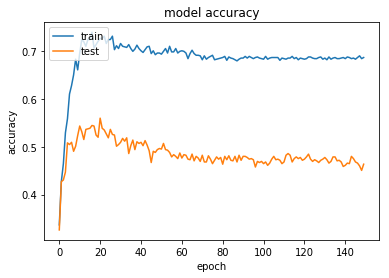

In [41]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

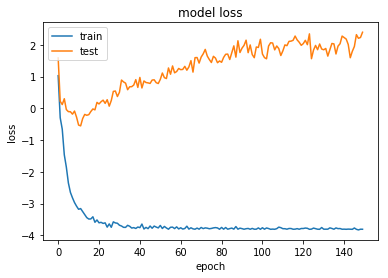

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predicting the sentiment scores for the test data

In [45]:
pred = model_mlp.predict(data, batch_size=32, verbose=1)

1632/1700 [===========================>..] - ETA: 13 - ETA: 2 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 0s

In [46]:
abc = pred.astype(int).flatten().flatten()
zxy = pd.DataFrame({'predictedvalues': abc})

In [53]:
len(spans)

800

In [57]:
predsubmission = pd.DataFrame({'id':idss,
                               'source': sources,
                               'cashtag':cashtags,
                               'spans':spanss,
                               'sentimentscore': sentscr
                               })

## Building the LSTM model

In [108]:
print('Build model...')
batch_size = 32
maxlen = 80

x_train_short = pad_sequences(x_train, maxlen=maxlen)
x_test_short = pad_sequences(x_train, maxlen=maxlen)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, 128))
model_lstm.add(LSTM(128, dropout=0.25, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='linear'))

# try using different optimizers and different optimizer configs
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
lstmhistory = model_lstm.fit(x_train_short, y_train, batch_size=batch_size, epochs=25,
          validation_data=(x_test_short, y_test))

Build model...
Train...
Train on 850 samples, validate on 850 samples
Epoch 1/25
850/850 [==============================] - ETA: 44s - loss: 6.4247 - acc: 0.25 - ETA: 22s - loss: 4.8894 - acc: 0.28 - ETA: 15s - loss: 3.7161 - acc: 0.29 - ETA: 12s - loss: 2.9776 - acc: 0.28 - ETA: 9s - loss: 2.4619 - acc: 0.2750 - ETA: 8s - loss: 2.0946 - acc: 0.265 - ETA: 7s - loss: 1.9185 - acc: 0.276 - ETA: 6s - loss: 1.8220 - acc: 0.281 - ETA: 5s - loss: 1.7132 - acc: 0.291 - ETA: 4s - loss: 1.5959 - acc: 0.296 - ETA: 4s - loss: 1.5039 - acc: 0.295 - ETA: 3s - loss: 1.4341 - acc: 0.289 - ETA: 3s - loss: 1.3634 - acc: 0.283 - ETA: 3s - loss: 1.2965 - acc: 0.299 - ETA: 2s - loss: 1.2584 - acc: 0.306 - ETA: 2s - loss: 1.2004 - acc: 0.312 - ETA: 2s - loss: 1.1676 - acc: 0.307 - ETA: 1s - loss: 1.1300 - acc: 0.302 - ETA: 1s - loss: 1.0972 - acc: 0.309 - ETA: 1s - loss: 1.0678 - acc: 0.307 - ETA: 1s - loss: 1.0211 - acc: 0.314 - ETA: 0s - loss: 0.9899 - acc: 0.313 - ETA: 0s - loss: 0.9650 - acc: 0.317 - E

850/850 [==============================] - ETA: 3s - loss: -2.8613 - acc: 0.75 - ETA: 3s - loss: -4.4360 - acc: 0.70 - ETA: 2s - loss: -3.4273 - acc: 0.76 - ETA: 2s - loss: -4.0388 - acc: 0.71 - ETA: 2s - loss: -4.3305 - acc: 0.71 - ETA: 2s - loss: -4.2557 - acc: 0.70 - ETA: 2s - loss: -4.2870 - acc: 0.71 - ETA: 2s - loss: -4.2348 - acc: 0.71 - ETA: 2s - loss: -4.1473 - acc: 0.71 - ETA: 2s - loss: -4.1215 - acc: 0.71 - ETA: 1s - loss: -4.0606 - acc: 0.72 - ETA: 1s - loss: -4.0868 - acc: 0.71 - ETA: 1s - loss: -3.9199 - acc: 0.72 - ETA: 1s - loss: -3.9233 - acc: 0.73 - ETA: 1s - loss: -3.9264 - acc: 0.72 - ETA: 1s - loss: -3.8039 - acc: 0.73 - ETA: 1s - loss: -3.7787 - acc: 0.73 - ETA: 1s - loss: -3.6507 - acc: 0.74 - ETA: 0s - loss: -3.7743 - acc: 0.73 - ETA: 0s - loss: -3.7074 - acc: 0.74 - ETA: 0s - loss: -3.6720 - acc: 0.74 - ETA: 0s - loss: -3.6411 - acc: 0.75 - ETA: 0s - loss: -3.6519 - acc: 0.74 - ETA: 0s - loss: -3.6006 - acc: 0.74 - ETA: 0s - loss: -3.5733 - acc: 0.74 - ETA: 0s

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


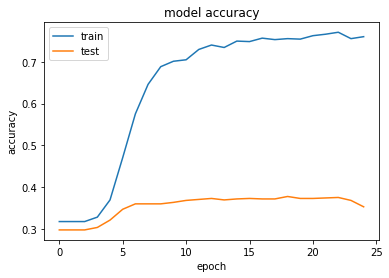

In [109]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(lstmhistory.history['acc'])
plt.plot(lstmhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
print('Build model...')
batch_size = 32
maxlen = 80

x_train_short = pad_sequences(x_train, maxlen=maxlen)
x_test_short = pad_sequences(x_train, maxlen=maxlen)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, 128))
model_lstm.add(LSTM(128, dropout=0.35, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='tanh'))

# try using different optimizers and different optimizer configs
model_lstm.compile(loss='binary_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

print('Train...')
lstmhistory1 = model_lstm.fit(x_train_short, y_train, batch_size=batch_size, epochs=65,
          validation_data=(x_test_short, y_test))

Build model...
Train...
Train on 850 samples, validate on 850 samples
Epoch 1/65
850/850 [==============================] - ETA: 41s - loss: 1.6008 - acc: 0.31 - ETA: 21s - loss: 1.1554 - acc: 0.31 - ETA: 14s - loss: 1.1395 - acc: 0.32 - ETA: 11s - loss: 0.9829 - acc: 0.31 - ETA: 9s - loss: 0.8562 - acc: 0.3187 - ETA: 7s - loss: 0.8912 - acc: 0.302 - ETA: 6s - loss: 0.8041 - acc: 0.317 - ETA: 5s - loss: 0.7639 - acc: 0.300 - ETA: 5s - loss: 0.7598 - acc: 0.305 - ETA: 4s - loss: 0.7393 - acc: 0.321 - ETA: 4s - loss: 0.7147 - acc: 0.312 - ETA: 3s - loss: 0.7160 - acc: 0.307 - ETA: 3s - loss: 0.7028 - acc: 0.317 - ETA: 2s - loss: 0.6909 - acc: 0.314 - ETA: 2s - loss: 0.6639 - acc: 0.322 - ETA: 2s - loss: 0.6425 - acc: 0.330 - ETA: 2s - loss: 0.6317 - acc: 0.336 - ETA: 1s - loss: 0.6040 - acc: 0.333 - ETA: 1s - loss: 0.6150 - acc: 0.330 - ETA: 1s - loss: 0.5938 - acc: 0.334 - ETA: 1s - loss: 0.5798 - acc: 0.334 - ETA: 0s - loss: 0.5900 - acc: 0.332 - ETA: 0s - loss: 0.5897 - acc: 0.331 - E

850/850 [==============================] - ETA: 2s - loss: -4.0050 - acc: 0.65 - ETA: 2s - loss: -4.2653 - acc: 0.67 - ETA: 2s - loss: -3.8370 - acc: 0.68 - ETA: 2s - loss: -4.0100 - acc: 0.69 - ETA: 2s - loss: -3.8697 - acc: 0.69 - ETA: 2s - loss: -3.8931 - acc: 0.70 - ETA: 2s - loss: -3.4782 - acc: 0.73 - ETA: 2s - loss: -3.2299 - acc: 0.73 - ETA: 2s - loss: -3.4289 - acc: 0.73 - ETA: 2s - loss: -3.4224 - acc: 0.73 - ETA: 1s - loss: -3.7013 - acc: 0.74 - ETA: 1s - loss: -3.5587 - acc: 0.73 - ETA: 1s - loss: -3.5536 - acc: 0.73 - ETA: 1s - loss: -3.5107 - acc: 0.73 - ETA: 1s - loss: -3.3732 - acc: 0.74 - ETA: 1s - loss: -3.1821 - acc: 0.74 - ETA: 1s - loss: -3.2886 - acc: 0.73 - ETA: 1s - loss: -3.2726 - acc: 0.74 - ETA: 0s - loss: -3.2122 - acc: 0.74 - ETA: 0s - loss: -3.2738 - acc: 0.74 - ETA: 0s - loss: -3.3303 - acc: 0.75 - ETA: 0s - loss: -3.3696 - acc: 0.75 - ETA: 0s - loss: -3.3746 - acc: 0.74 - ETA: 0s - loss: -3.4848 - acc: 0.74 - ETA: 0s - loss: -3.4842 - acc: 0.74 - ETA: 0s

850/850 [==============================] - ETA: 2s - loss: -3.5106 - acc: 0.78 - ETA: 2s - loss: -4.0214 - acc: 0.70 - ETA: 2s - loss: -4.1914 - acc: 0.73 - ETA: 2s - loss: -3.8981 - acc: 0.74 - ETA: 2s - loss: -4.3227 - acc: 0.75 - ETA: 2s - loss: -4.4415 - acc: 0.73 - ETA: 2s - loss: -4.2966 - acc: 0.74 - ETA: 2s - loss: -3.9477 - acc: 0.75 - ETA: 2s - loss: -3.7324 - acc: 0.74 - ETA: 1s - loss: -3.7073 - acc: 0.73 - ETA: 1s - loss: -3.6895 - acc: 0.73 - ETA: 1s - loss: -3.6756 - acc: 0.72 - ETA: 1s - loss: -3.5473 - acc: 0.73 - ETA: 1s - loss: -3.5790 - acc: 0.73 - ETA: 1s - loss: -3.5375 - acc: 0.73 - ETA: 1s - loss: -3.5039 - acc: 0.72 - ETA: 1s - loss: -3.4420 - acc: 0.71 - ETA: 0s - loss: -3.3815 - acc: 0.72 - ETA: 0s - loss: -3.4421 - acc: 0.72 - ETA: 0s - loss: -3.4207 - acc: 0.71 - ETA: 0s - loss: -3.4974 - acc: 0.71 - ETA: 0s - loss: -3.4771 - acc: 0.72 - ETA: 0s - loss: -3.4394 - acc: 0.72 - ETA: 0s - loss: -3.3794 - acc: 0.72 - ETA: 0s - loss: -3.3664 - acc: 0.71 - ETA: 0s

850/850 [==============================] - ETA: 2s - loss: -1.0073 - acc: 0.65 - ETA: 2s - loss: -2.5184 - acc: 0.73 - ETA: 2s - loss: -2.3494 - acc: 0.72 - ETA: 2s - loss: -3.2678 - acc: 0.71 - ETA: 2s - loss: -3.5204 - acc: 0.74 - ETA: 2s - loss: -3.3443 - acc: 0.74 - ETA: 2s - loss: -3.3702 - acc: 0.74 - ETA: 2s - loss: -3.4439 - acc: 0.72 - ETA: 2s - loss: -3.2851 - acc: 0.72 - ETA: 1s - loss: -3.4470 - acc: 0.73 - ETA: 1s - loss: -3.6374 - acc: 0.72 - ETA: 1s - loss: -3.9219 - acc: 0.73 - ETA: 1s - loss: -3.9300 - acc: 0.72 - ETA: 1s - loss: -3.8651 - acc: 0.72 - ETA: 1s - loss: -3.7417 - acc: 0.71 - ETA: 1s - loss: -3.8515 - acc: 0.71 - ETA: 1s - loss: -3.7429 - acc: 0.70 - ETA: 1s - loss: -3.6189 - acc: 0.70 - ETA: 0s - loss: -3.5047 - acc: 0.70 - ETA: 0s - loss: -3.4553 - acc: 0.70 - ETA: 0s - loss: -3.4586 - acc: 0.70 - ETA: 0s - loss: -3.3466 - acc: 0.69 - ETA: 0s - loss: -3.4639 - acc: 0.69 - ETA: 0s - loss: -3.4453 - acc: 0.69 - ETA: 0s - loss: -3.4879 - acc: 0.69 - ETA: 0s

850/850 [==============================] - ETA: 2s - loss: -2.5182 - acc: 0.65 - ETA: 2s - loss: -3.7749 - acc: 0.68 - ETA: 2s - loss: -3.1826 - acc: 0.68 - ETA: 2s - loss: -3.0165 - acc: 0.63 - ETA: 2s - loss: -3.0176 - acc: 0.63 - ETA: 2s - loss: -2.9252 - acc: 0.61 - ETA: 2s - loss: -3.0829 - acc: 0.64 - ETA: 2s - loss: -3.0112 - acc: 0.64 - ETA: 2s - loss: -3.1803 - acc: 0.65 - ETA: 1s - loss: -3.2149 - acc: 0.65 - ETA: 1s - loss: -3.2877 - acc: 0.65 - ETA: 1s - loss: -3.4755 - acc: 0.66 - ETA: 1s - loss: -3.4406 - acc: 0.67 - ETA: 1s - loss: -3.5511 - acc: 0.67 - ETA: 1s - loss: -3.6832 - acc: 0.68 - ETA: 1s - loss: -3.7678 - acc: 0.68 - ETA: 1s - loss: -3.8119 - acc: 0.68 - ETA: 0s - loss: -3.6275 - acc: 0.68 - ETA: 0s - loss: -3.5161 - acc: 0.68 - ETA: 0s - loss: -3.5418 - acc: 0.68 - ETA: 0s - loss: -3.4917 - acc: 0.68 - ETA: 0s - loss: -3.4700 - acc: 0.68 - ETA: 0s - loss: -3.4392 - acc: 0.68 - ETA: 0s - loss: -3.4009 - acc: 0.68 - ETA: 0s - loss: -3.4047 - acc: 0.68 - ETA: 0s

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


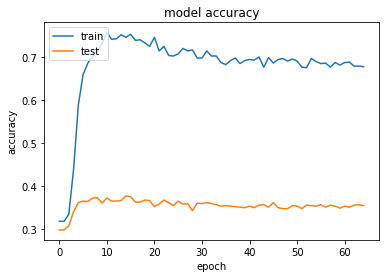

In [115]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(lstmhistory1.history['acc'])
plt.plot(lstmhistory1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
predicted = predsubmission.join(zxy)
predicted[:10]

,cashtag,id,sentimentscore,source,spans,predictedvalues
0,$FB,719659409228451840,1,twitter,[watching for bounce tomorrow],0
1,$LUV,719904304207962112,1,twitter,[record number of passengers served in 2015],1
2,$NFLX,5329774,-1,stocktwits,[out $NFLX -.35],0
3,$DIA,719891468173844480,1,twitter,"[Looking for a strong bounce, Lunchtime rally ...",1
4,$PLUG,20091246,1,stocktwits,[Very intrigued with the technology and growth...,1
5,$GMCR,5819749,0,stocktwits,"[short worked, puts up]",-1
6,$IBM,709741154393133056,0,twitter,[overbought],0
7,$JOSB,17892972,-1,stocktwits,"[absolute garbage still up, stores TOTALLY EMP...",0
8,$CSTM,709834259687710720,-1,twitter,[Biggest Market Losers],0
9,$PYPL,708481442079068160,1,twitter,[Love this company long time.],0


In [60]:
predicted = predicted[['id','source','cashtag','sentimentscore','predictedvalues']]
predicted[:5]

,id,source,cashtag,sentimentscore,predictedvalues
0,719659409228451840,twitter,$FB,1,0
1,719904304207962112,twitter,$LUV,1,1
2,5329774,stocktwits,$NFLX,-1,0
3,719891468173844480,twitter,$DIA,1,1
4,20091246,stocktwits,$PLUG,1,1


## Building CNN model

In [158]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='linear')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='linear')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='linear')(x)
x = MaxPooling1D(7)(x)  # modified from example since our seq len is 300 
x = Flatten()(x)
x = Dense(128, activation='linear')(x)
preds = Dense(1, activation='tanh')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 300, 200)          494400    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 128)          128128    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 59, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 55, 128)           82048     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 11, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 128)            82048     
__________

In [168]:

print('Training model.')
cnnhistory = model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=200, batch_size=128)

Training model.
Train on 850 samples, validate on 850 samples
Epoch 1/200
850/850 [==============================] - ETA: 1s - loss: -3.9010 - acc: 0.66 - ETA: 0s - loss: -3.7764 - acc: 0.65 - ETA: 0s - loss: -3.6089 - acc: 0.66 - ETA: 0s - loss: -3.4921 - acc: 0.66 - ETA: 0s - loss: -3.3739 - acc: 0.66 - 0s - loss: -3.3708 - acc: 0.6600 - val_loss: 0.1098 - val_acc: 0.4988
Epoch 2/200
850/850 [==============================] - ETA: 0s - loss: -2.3925 - acc: 0.66 - ETA: 0s - loss: -2.8504 - acc: 0.63 - ETA: 0s - loss: -3.1961 - acc: 0.64 - 0s - loss: -3.3713 - acc: 0.6612 - val_loss: 0.1692 - val_acc: 0.5000
Epoch 3/200
850/850 [==============================] - ETA: 0s - loss: -3.1437 - acc: 0.64 - ETA: 0s - loss: -3.3542 - acc: 0.64 - ETA: 0s - loss: -3.1941 - acc: 0.64 - ETA: 0s - loss: -3.2909 - acc: 0.66 - 0s - loss: -3.3707 - acc: 0.6600 - val_loss: 0.1799 - val_acc: 0.5118
Epoch 4/200
850/850 [==============================] - ETA: 0s - loss: -4.5332 - acc: 0.68 - ETA: 0s - loss

850/850 [==============================] - ETA: 0s - loss: -3.0146 - acc: 0.71 - ETA: 0s - loss: -3.1868 - acc: 0.67 - ETA: 0s - loss: -3.4458 - acc: 0.67 - ETA: 0s - loss: -3.3741 - acc: 0.66 - 0s - loss: -3.3709 - acc: 0.6612 - val_loss: 0.5193 - val_acc: 0.4882
Epoch 63/200
850/850 [==============================] - ETA: 0s - loss: -3.6517 - acc: 0.60 - ETA: 0s - loss: -3.6098 - acc: 0.64 - ETA: 0s - loss: -3.4748 - acc: 0.66 - ETA: 0s - loss: -3.4187 - acc: 0.67 - 0s - loss: -3.3711 - acc: 0.6612 - val_loss: 0.6413 - val_acc: 0.4882
Epoch 64/200
850/850 [==============================] - ETA: 0s - loss: -2.5125 - acc: 0.63 - ETA: 0s - loss: -3.1870 - acc: 0.68 - ETA: 0s - loss: -3.3460 - acc: 0.67 - 0s - loss: -3.3708 - acc: 0.6600 - val_loss: 0.6608 - val_acc: 0.4906
Epoch 65/200
850/850 [==============================] - ETA: 0s - loss: -4.1473 - acc: 0.68 - ETA: 0s - loss: -3.0589 - acc: 0.63 - ETA: 0s - loss: -3.4956 - acc: 0.65 - 0s - loss: -3.3709 - acc: 0.6612 - val_loss: 0.

850/850 [==============================] - ETA: 0s - loss: -3.6472 - acc: 0.68 - ETA: 0s - loss: -3.3549 - acc: 0.69 - ETA: 0s - loss: -3.3711 - acc: 0.68 - 0s - loss: -3.3709 - acc: 0.6635 - val_loss: 0.1512 - val_acc: 0.5012
Epoch 125/200
850/850 [==============================] - ETA: 0s - loss: -3.1409 - acc: 0.60 - ETA: 0s - loss: -3.6073 - acc: 0.66 - ETA: 0s - loss: -3.5980 - acc: 0.67 - ETA: 0s - loss: -3.4802 - acc: 0.66 - 0s - loss: -3.3709 - acc: 0.6624 - val_loss: 0.2387 - val_acc: 0.5000
Epoch 126/200
850/850 [==============================] - ETA: 0s - loss: -3.0184 - acc: 0.65 - ETA: 0s - loss: -3.1030 - acc: 0.65 - ETA: 0s - loss: -3.3225 - acc: 0.65 - 0s - loss: -3.3711 - acc: 0.6659 - val_loss: 0.2769 - val_acc: 0.5035
Epoch 127/200
850/850 [==============================] - ETA: 0s - loss: -2.8962 - acc: 0.71 - ETA: 0s - loss: -3.0641 - acc: 0.67 - ETA: 0s - loss: -3.3471 - acc: 0.66 - 0s - loss: -3.3709 - acc: 0.6671 - val_loss: 0.4217 - val_acc: 0.5153
Epoch 128/20

850/850 [==============================] - ETA: 0s - loss: -2.8886 - acc: 0.62 - ETA: 0s - loss: -3.2688 - acc: 0.65 - ETA: 0s - loss: -3.5210 - acc: 0.66 - 0s - loss: -3.3702 - acc: 0.6624 - val_loss: 0.2894 - val_acc: 0.4588
Epoch 186/200
850/850 [==============================] - ETA: 0s - loss: -4.4058 - acc: 0.73 - ETA: 0s - loss: -3.8178 - acc: 0.69 - ETA: 0s - loss: -3.5721 - acc: 0.66 - 0s - loss: -3.3703 - acc: 0.6612 - val_loss: 0.3482 - val_acc: 0.4918
Epoch 187/200
850/850 [==============================] - ETA: 0s - loss: -2.5183 - acc: 0.65 - ETA: 0s - loss: -3.6032 - acc: 0.64 - ETA: 0s - loss: -3.3959 - acc: 0.66 - 0s - loss: -3.3711 - acc: 0.6612 - val_loss: 0.3707 - val_acc: 0.4953
Epoch 188/200
850/850 [==============================] - ETA: 0s - loss: -2.5184 - acc: 0.57 - ETA: 0s - loss: -3.0221 - acc: 0.62 - ETA: 0s - loss: -3.1787 - acc: 0.64 - ETA: 0s - loss: -3.0815 - acc: 0.64 - 0s - loss: -3.3712 - acc: 0.6612 - val_loss: 0.3897 - val_acc: 0.4953
Epoch 189/20

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


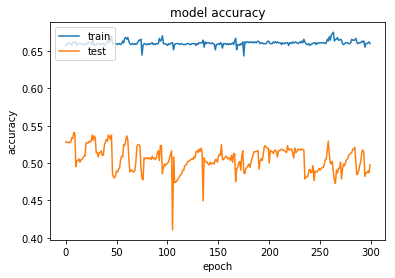

In [167]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Writing the predicted scores to CSV file

In [61]:
predicted.to_csv('Task1_test.csv', index=False)

## Calculating the cosine value

In [62]:
zz = np.array(abc).reshape(1,-1)

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(vvv,
                  zz)

array([[ 0.52882819]])